In [2]:
#Dependancies
import numpy as np
import math
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve, least_squares, minimize
from scipy.stats import qmc 
from scipy.linalg import norm
import random
import matplotlib.animation
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.signal import argrelmin, argrelmax
import matplotlib.pyplot as plt
from numba import jit
from tabulate import tabulate

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
@jit
def model(t, X, V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω):
    
    """The NPZV system, formulated with 7 state variables defined below. 
    Defined to be used with the numerical integrating function, solve_ivp."""
    
    N_n = X[0] #New nutrients (Nitrate)
    N_r = X[1] #Recycled Nutrients (Ammonium)
    P_U = X[2] #Susceptible Hosts
    P_I = X[3] #Infected Hosts
    Z   = X[4] #Zooplankton
    V_I = X[5] #Internal viruses from host nucleotide recycling 
               #and de novo nucleotide synthesis
    V_E = X[6] #Free (extracellular) viruses 
    
    alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
    beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3
    
    if V_I == 0:  ν_i = 0 #avoid divison by 0 when evaluating ν_i
        
    else:
        ν_i = V_I / ((beta / alpha) * P_I + V_I)
     
    #Useful abreviations
    P = P_U + P_I
    N = N_n + N_r
    nutr_lim = N / (K_N + N)
     
    if N == 0: nutr_lim, N = (0, 1) #avoid divison by 0 when evaluating nutrient ratios

    light_lim = np.log((K_I + I_0 / K_I)) / K_h  #light limitation term
    
    psi = V_max * nutr_lim * light_lim
    
    #Defining the scaling factors that continuously reduce the affect of growth
    #as state variables reach ecologically unrealistic densities (e.g. 1e-20)
    thresh = 1e-8  #threshold for when growth damping begins
    
    P_U_scale = 1                
    if P_U < thresh:             
        P_U_scale = P_U / thresh 
       
    P_I_scale = 1
    if P_I < thresh:
        P_I_scale = P_I / thresh

    Z_scale = 1 
    if Z < thresh:
        Z_scale = Z / thresh

    V_I_scale = 1
    if V_I < thresh:
        V_I_scale = V_I / thresh  
    
    V_E_scale = 1
    if V_E < thresh:
        V_E_scale = V_E / thresh   
         
    #Uninfected Phytoplankton
    P_U_growth  = P_U_scale * (P_U + P_I_scale * μ_u * P_I) * psi
    
    P_U_grazing = P_U * g * Z_scale * Z / K_P
    P_U_mort    = P_U * λ_P
    P_U_adsorp  = P_U * P_I_scale * (1 - ν_x) * φ * μ_s * V_E
    P_U_entrain = P_U * ω 
    
    P_U_dt = P_U_growth - P_U_grazing - P_U_mort - P_U_adsorp - P_U_entrain
    
    #Infected Phytoplankton
    P_I_growth   = P_I_scale * (1 - P_U_scale * μ_u) * P_I * psi
    P_I_adsorp   = P_I_scale * (1 - ν_x) * φ * μ_s * P_U * V_E
    
    P_I_grazing  = P_I * Z_scale * g * Z / K_P
    P_I_mort     = P_I * λ_P
    P_I_nt_recyc = P_I * ν_i * μ_V
    P_I_lysis    = P_I * ν_i * δ
    P_I_entrain  = P_I * ω
    
    P_I_dt = P_I_growth + P_I_adsorp - P_I_grazing \
            - P_I_mort - P_I_nt_recyc - P_I_lysis - P_I_entrain
    
    #Zooplankton
    Z_assim   = Z * Z_scale * γ_Z * g * (P + V_I) / K_P
    Z_mort    = Z * (λ_Z + λ_Z_hat * Z)
    Z_entrain = Z * ω

    Z_dt = Z_assim - Z_mort - Z_entrain
    
    #Intracellular viruses
    V_I_growth  = V_I_scale * (beta / alpha) * ν_i * (μ_V + (nutr_lim * μ_V_prime)) * P_I
    V_I_adsorp  = V_I_scale * (beta / alpha) * ν_x * φ * μ_s * P_U * V_E
    
    V_I_grazing = V_I * Z_scale * g * Z / K_P
    V_I_lysis   = V_I * V_E_scale * ν_i * δ
    V_I_h_mort  = V_I * λ_P
    V_I_entrain = V_I * ω
    
    V_I_dt = V_I_growth + V_I_adsorp - V_I_lysis \
            - V_I_grazing - V_I_h_mort - V_I_entrain
    
    #Extracellular viruses
    V_E_h_mort  = V_E_scale * V_I * μ_r * λ_P

    V_E_adsorp  = V_I_scale * (beta / alpha) * ν_x * φ * μ_s * P_U * V_E
    V_E_mort    = λ_E * V_E
    V_E_entrain = V_E * ω
    
    V_E_dt = V_I_lysis + V_E_h_mort - V_E_adsorp - V_E_mort - V_E_entrain
    
    
    #Nitrate
    N_n_deplet    = (N_n / N) * (P_U_growth + P_I_growth)
    N_n_intracell = V_I_scale * (N_n / N) * (beta / alpha) * ν_i * P_I * (nutr_lim * μ_V_prime)
    N_n_entrain   = ω * N_n 
    
    N_n_dt = - N_n_deplet - N_n_intracell - N_n_entrain
            
        
    #Recycled nutrients
    N_r_deplet    = (N_r / N) * (P_U_growth + P_I_growth)
    
    nt_recyc      = ν_i * P_I * (1 - V_I_scale * beta / alpha) * μ_V
    denovo_syn    = ν_i * P_I * V_I_scale * (N_r / N) * (beta / alpha) * (nutr_lim * μ_V_prime)
    N_r_intracell = nt_recyc - denovo_syn
    
    N_r_mort    = λ_P * (P + (1 - V_E_scale * μ_r) * V_I)
    N_r_sloppy  = Z_scale * (1 - γ_Z) * g * Z * (P + V_I) / K_P
    N_r_entrain = N_r * ω
    
    N_r_remin  = (μ_P * N_r_mort) + V_E_mort + (μ_delta * P_I_lysis) \
                + (μ_g * N_r_sloppy) + (μ_Z * Z_mort) - N_r_entrain

    N_r_export = (1 - μ_P) * N_r_mort + (1 - μ_delta) * P_I_lysis \
                + (1 - μ_g) * N_r_sloppy + (1 - μ_Z) * Z_mort
    
    N_r_dt = - N_r_deplet + N_r_intracell + N_r_remin + N_r_export
            
    
    return N_n_dt, N_r_dt, P_U_dt, P_I_dt, Z_dt, V_I_dt, V_E_dt


In [3]:
#Estimating viral abundance based off ratio of host to viral entitiy

def est_viral_abund(r, Pu_0, alpha, beta, S_ind, V_ind):
    
    """
    r     (int)  : 1:r ratio of phytoplankton to viral enities
    Pu_0  (float): condition defining initial uninfected phytoplankton abundance
    alpha (float): conversion term for host related variables
    beta  (float): conversion term for virus related variables
    S_ind (float): Nucleotides per individual host
    V_ind (float): Nucleotides per individual virus
    """
    
    S_i = Pu_0 / alpha / S_ind  #individual hosts per ml
    
    V_est = r * S_i * V_ind * beta #mmol N / m^3
    
    return V_est

In [4]:
#Parameterization

alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3

V_ind     = 4e5        # NT per individual virus, Table S1
S_ind     = 1.42e8     # NT per individual host, Table S1

V_max     = 1.4              # Host growth rate
γ_Z       = .4               # Growth rate / Assimilation frequency 
φ         = 3.5e-10 / beta   # Viral adsorption rate, m^3 / (mmol * day)
g         = 1.4              # d^-1 Maximum specific grazing rate

ν_x       = V_ind / (V_ind + S_ind) # Proportion of nutrients originating 
                                    # from virus in host-virus pair
    
λ_P       = .05        # Mortality & Respiration rate
λ_Z       = .05        # d^-1, Linear mortality & respiration & egestion
λ_Z_hat   = .1         # Quadratic mortality & respiration & egestion
λ_E       = .05        # ARBITRARY VALUE: Extracellular virus mortality 
δ         = .45        # Host lysis rate

μ_V       = .5         # Max host NT recycling rate 
μ_V_prime = 1.6        # Max de novo NT synthesis rate
μ_u       = 0
μ_r       = 0          # Viral assimilation fraction related to host mortality
μ_s       = 1
μ_P       = .4         # Remineralization fraction due to mortality
μ_delta   = .4         # ARBITRARY VALUE: Remineralization fraction due to lysis
μ_g       = .4         # Remineralization fraction due to sloppy-eating
μ_Z       = .4         # Remineralization fraction due to grazer mortality

K_N       = .1         # mmol m^-3 # Half-saturation constant for nutrient limitation
K_I       = 1          # Half-saturation for light limitation
K_h       = 1          # Half-saturation for ... ?
K_P       = 2.8        # mmol m^-3, Half-saturation constant for grazing of P
I_0       = (np.e - 1) # Compensation irradiance

ω         = 0 # Entraintment term

param_labels = ['V_max', 'γ_Z', 'φ', 'g', 'ν_x', 'λ_P', 'λ_Z', 'λ_Z_hat', 'λ_E', 
                'δ', 'μ_V', 'μ_V_prime', 'μ_u', 'μ_r', 'μ_s', 'μ_P', 'μ_delta', 
                'μ_g', 'μ_Z', 'K_N', 'K_I', 'K_h', 'K_P', 'I_0', 'ω']

param = [V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω]

In [108]:
#Print parameterization

#Param labels for printing
param_labels_fp = ['V_max', 'γ_Z', 'φ = 3.5e-10 / beta', 'g', 'ν_x = V_ind / (V_ind + S_ind)', 
                   'λ_P', 'λ_Z', 'λ_Z_hat', 'λ_E', 'δ', 'μ_V', 'μ_V_prime', 'μ_u', 'μ_r', 'μ_s', 
                   'μ_P', 'μ_delta', 'μ_g', 'μ_Z', 'K_N', 'K_I', 'K_h', 'K_P', 'I_0 = e - 1', 'ω']

table = np.empty((5,5), dtype=object)
i = 0

for col in range(5):
    for row in range(5):
        
        table[row][col] = f"{param_labels_fp[i]} = {round(param[i], 4)}"
        i += 1

print(tabulate(table, tablefmt='fancy_grid'))

╒════════════════════════════════════════╤═══════════════╤═════════════════╤═══════════════╤══════════════════════╕
│ V_max = 1.4                            │ λ_P = 0.05    │ μ_V = 0.5       │ μ_P = 0.4     │ K_I = 1              │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ γ_Z = 0.4                              │ λ_Z = 0.05    │ μ_V_prime = 1.6 │ μ_delta = 0.4 │ K_h = 1              │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ φ = 3.5e-10 / beta = 110236.2205       │ λ_Z_hat = 0.1 │ μ_u = 0         │ μ_g = 0.4     │ K_P = 2.8            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ g = 1.4                                │ λ_E = 0.05    │ μ_r = 0         │ μ_Z = 0.4     │ I_0 = e - 1 = 1.7183 │
├────────────────────────────────────────┼───────────────┼──────────────

**Generating Extensive Solution Field**

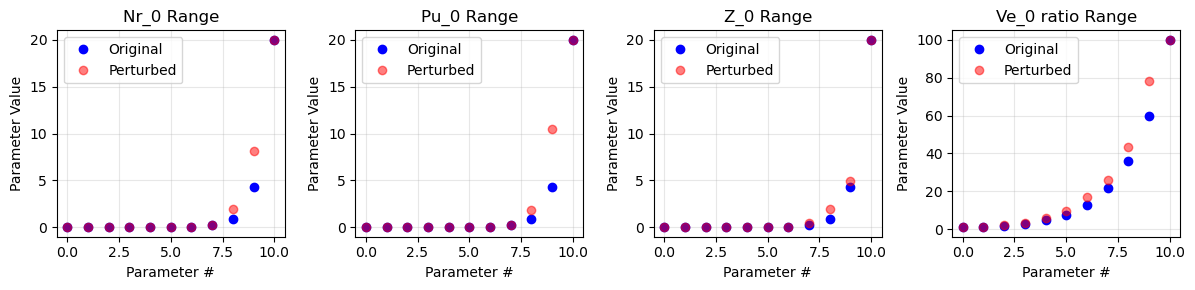

In [109]:
# # PRACTICE: Integraing random component into the initial condition selection with visual 

# Define initial ranges
N_r_range = np.logspace(-5, 1, 10) * 2
P_U_range = np.logspace(-5, 1, 10) * 2
Z_range   = np.logspace(-5, 1, 10) * 2

V_E_range = np.logspace(0, 2, 10) #range of r for 1/r ratio of host to viruses

ranges = N_r_range, P_U_range, Z_range, V_E_range
range_names = "Nr_0", "Pu_0", "Z_0", "Ve_0 ratio"

# Perturbing range values with perturbations defined 
# between the gaps of the original range points

fig, axs = plt.subplots(1, 4, figsize = (12, 3))

count = 0
for r, state_range in enumerate(ranges):

    #insert copy original starting value, then perturb
    
    state_range = np.insert(state_range, 0, state_range[0])
    axs[count].plot(state_range, 'o', color = 'blue', label = 'Original')
    
    for i in range(1, len(state_range) - 1):
        
        range_gap = state_range[i + 1] - state_range[i]
        pert = random.uniform(0, range_gap) / 2

        state_range[i] += pert
    
    axs[count].plot(state_range, 'o', color = 'red', alpha=.5, label="Perturbed")
    
    axs[count].set_title(range_names[r] + " Range")
    axs[count].set_xlabel("Parameter #")
    axs[count].set_ylabel("Parameter Value")
    axs[count].legend()
    axs[count].grid(alpha=.3)
    
    count += 1
    
plt.tight_layout()
plt.show()

In [110]:
sols = []
t_span = 700

# shifting range values with perturbations defined 
# between the gaps of the original range points
for r, state_range in enumerate(ranges):

    #insert copy of original starting value, then perturb following values
    state_range = np.insert(state_range, 0, state_range[0])
    
    for i in range(1, len(state_range) - 1):
        
        range_gap = state_range[i + 1] - state_range[i]
        pert = random.uniform(0, range_gap) / 2

        state_range[i] += pert
        
Pi_0 = 1e-7
Vi_0 = 1e-7

count = 0 #count how many solutions meet qualifications

for Nr_0 in N_r_range:
    for Pu_0 in P_U_range:
        for Z_0 in Z_range:
            for r in V_E_range:
                
                Ve_0 = est_viral_abund(r, Pu_0, alpha, beta, S_ind, V_ind)
                
                z0 = [0, Nr_0, Pu_0, Pi_0, Z_0, Vi_0, Ve_0]
                
                if sum(z0) > 4: #If the combination of initial state values
                    continue     #is greater than the maximum allowable total N,
                                 #then move to next combination
                count += 1
                #print(f'{count:<3} N_t = {sum(z0):<8.2} Nr_0: {Nr_0:<7.2} Pu_0: {Pu_0:<7.2} Pi_0: {Pi_0:<7.2} Z_0: {Z_0:<7.2} Vi_0: {Vi_0:<7.2} Ve_0: {Ve_0:<7.2}')

                solution = solve_ivp(model, [0, t_span], z0, args=param, 
                                     min_step = 1e-8, max_step = .1, method = 'LSODA')     

                sols.append((z0, solution))
                
count

5120

In [8]:
#Pretty print ranges
labels_fp = "N_n", "N_r", "P_U", "P_I", "Z", "V_I", "V_E"
ranges = '0', N_r_range, P_U_range, '1e-7', Z_range, '1e-7', [est_viral_abund(r, Pu_0, alpha, beta, S_ind, V_ind) for r in V_E_range]

table = np.empty((8, 4), dtype=object)
i = 0

table[0] = ["State", "Min", "Max", "Steps"]

for row in range(1, 8):
    
    table[row][0] = f'{labels_fp[i]}'
    
    if type(ranges[i]) != str:
        table[row][1] = f'{round(min(ranges[i]), 5)}'
        table[row][2] = f'{round(max(ranges[i]), 5)}'
        table[row][3] = f'{len(ranges[i])}'
        
    else:
        table[row][1] = f'{ranges[i]}'
        table[row][2] = f'{ranges[i]}'        
        table[row][3] = f'0'

    i += 1

print(tabulate(table, tablefmt='fancy_grid'))

╒═══════╤═════════╤════════╤═══════╕
│ State │ Min     │ Max    │ Steps │
├───────┼─────────┼────────┼───────┤
│ N_n   │ 0       │ 0      │ 0     │
├───────┼─────────┼────────┼───────┤
│ N_r   │ 2e-05   │ 20.0   │ 10    │
├───────┼─────────┼────────┼───────┤
│ P_U   │ 2e-05   │ 20.0   │ 10    │
├───────┼─────────┼────────┼───────┤
│ P_I   │ 1e-7    │ 1e-7   │ 0     │
├───────┼─────────┼────────┼───────┤
│ Z     │ 2e-05   │ 20.0   │ 10    │
├───────┼─────────┼────────┼───────┤
│ V_I   │ 1e-7    │ 1e-7   │ 0     │
├───────┼─────────┼────────┼───────┤
│ V_E   │ 0.00012 │ 0.0121 │ 10    │
╘═══════╧═════════╧════════╧═══════╛


In [9]:
sols[0] #reutnrs tuple of initial conditions + solution set

([0, 2e-05, 2e-05, 1e-07, 2e-05, 1e-07, 1.20952380952381e-10],
   message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 0.000e+00  1.000e-01 ...  6.999e+02  7.000e+02]
         y: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
             [ 2.000e-05  2.021e-05 ...  6.020e-05  6.020e-05]
             ...
             [ 1.000e-07  9.991e-08 ...  8.204e-13  8.204e-13]
             [ 1.210e-10  2.090e-10 ...  7.336e-23  7.299e-23]]
       sol: None
  t_events: None
  y_events: None
      nfev: 9493
      njev: 353
       nlu: 353)

**Various visualization schemes**

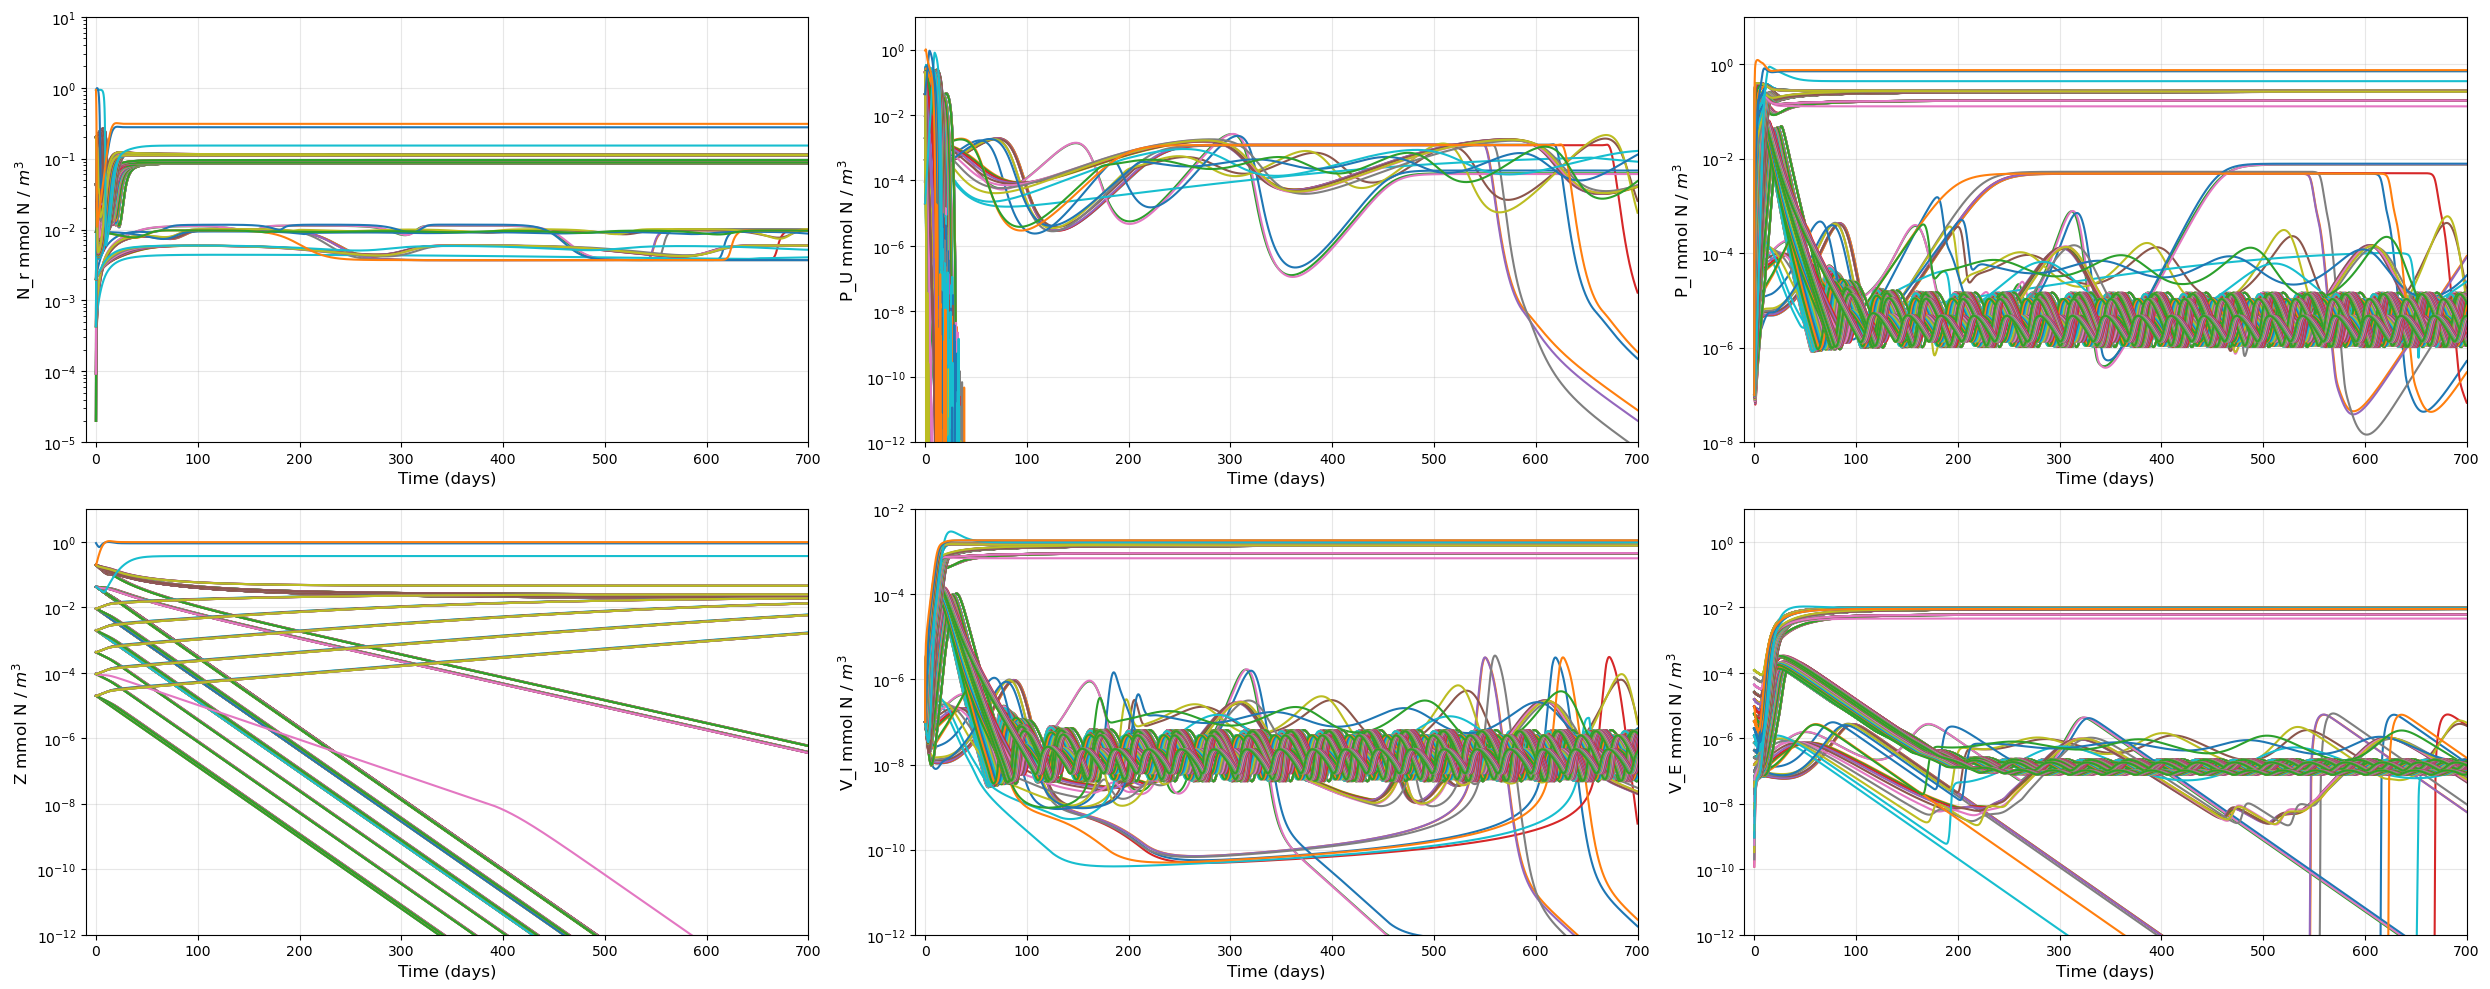

In [39]:
# Plotting all solutions for each state variable to determine 
# where steady states lie based on initial conditions

%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(25, 10))
fig.subplots_adjust(bottom=0.3, wspace=0.5)

for i, (z0, solution) in enumerate(osc_sols):

    axs[0][0].plot(solution.t, solution.y[1])
    axs[0][0].set_ylabel(r'N_r mmol N / $m^3$', fontsize=12)
    
    axs[0][1].plot(solution.t, solution.y[2])
    axs[0][1].set_ylabel(r'P_U mmol N / $m^3$', fontsize=12)
    
    axs[0][2].plot(solution.t, solution.y[3])
    axs[0][2].set_ylabel(r'P_I mmol N / $m^3$', fontsize=12)
    
    axs[1][0].plot(solution.t, solution.y[4])
    axs[1][0].set_ylabel(r'Z mmol N / $m^3$', fontsize=12)
    
    axs[1][1].plot(solution.t, solution.y[5], label = f"N_T = {sum(z0):<10.3} z0 = {z0}")
    axs[1][1].set_ylabel(r'V_I mmol N / $m^3$', fontsize=12)
    
    axs[1][2].plot(solution.t, solution.y[6])
    axs[1][2].set_ylabel(r'V_E mmol N / $m^3$', fontsize=12)
    
    
for ax in axs:
    for subax in ax:
        subax.grid(alpha=.3)
        subax.set_xlabel('Time (days)', fontsize=12)
        subax.set_xlim(-10, 700)
        subax.set_yscale('log')
        
axs[0][0].set_ylim(1e-5, 10) 
axs[0][1].set_ylim(1e-12, 10) 
axs[0][2].set_ylim(1e-8, 10) 
axs[1][0].set_ylim(1e-12, 10) 
axs[1][1].set_ylim(1e-12, 1e-2) 
axs[1][2].set_ylim(1e-12, 10) 

plt.tight_layout()
#axs[0][1].set_ylim(1e-10, 1e2)
#axs[1][1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3))


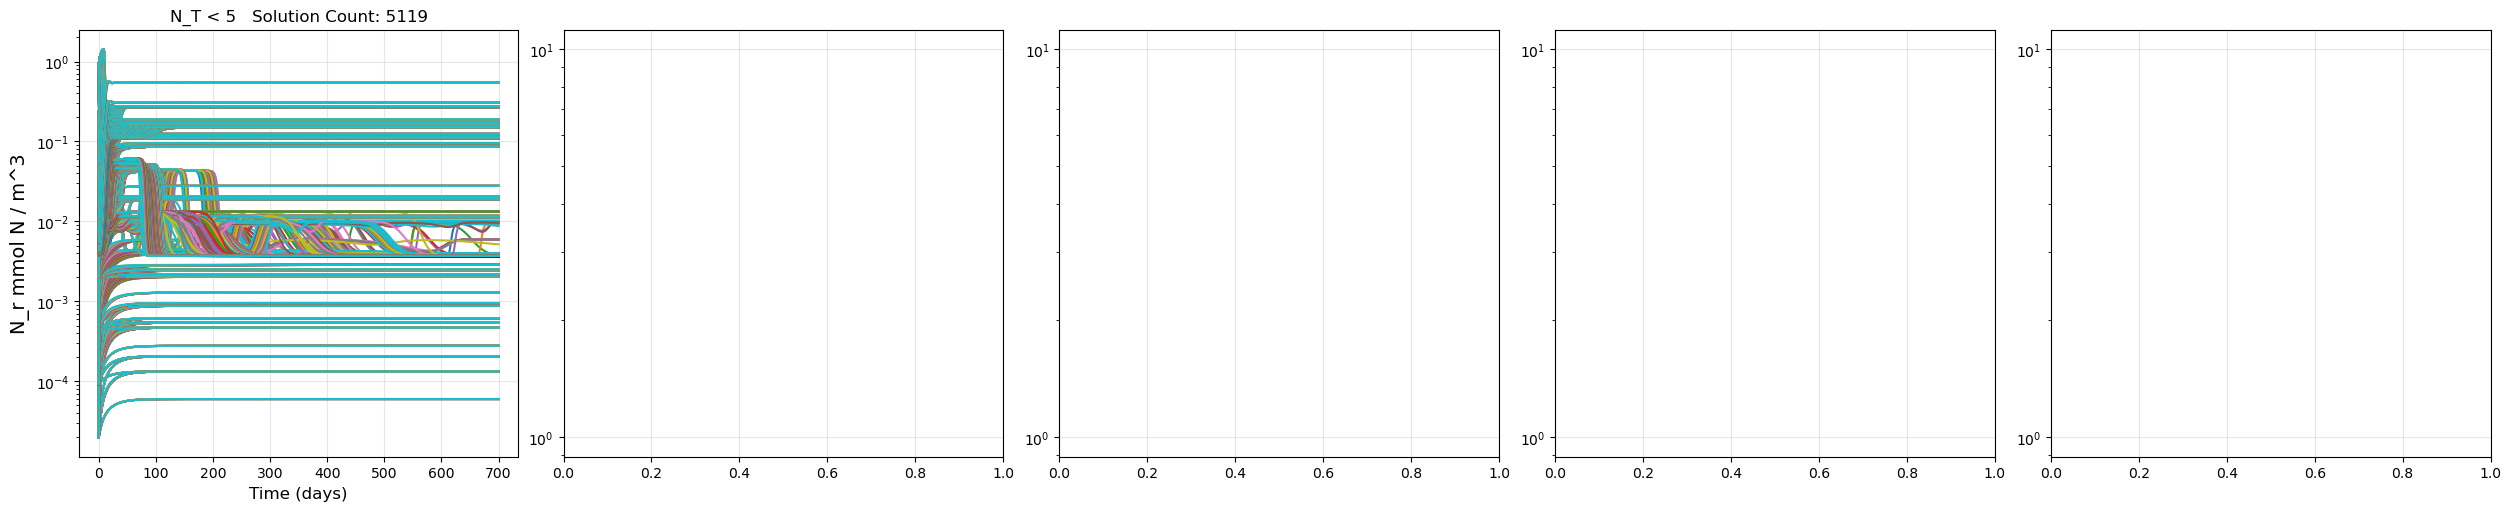

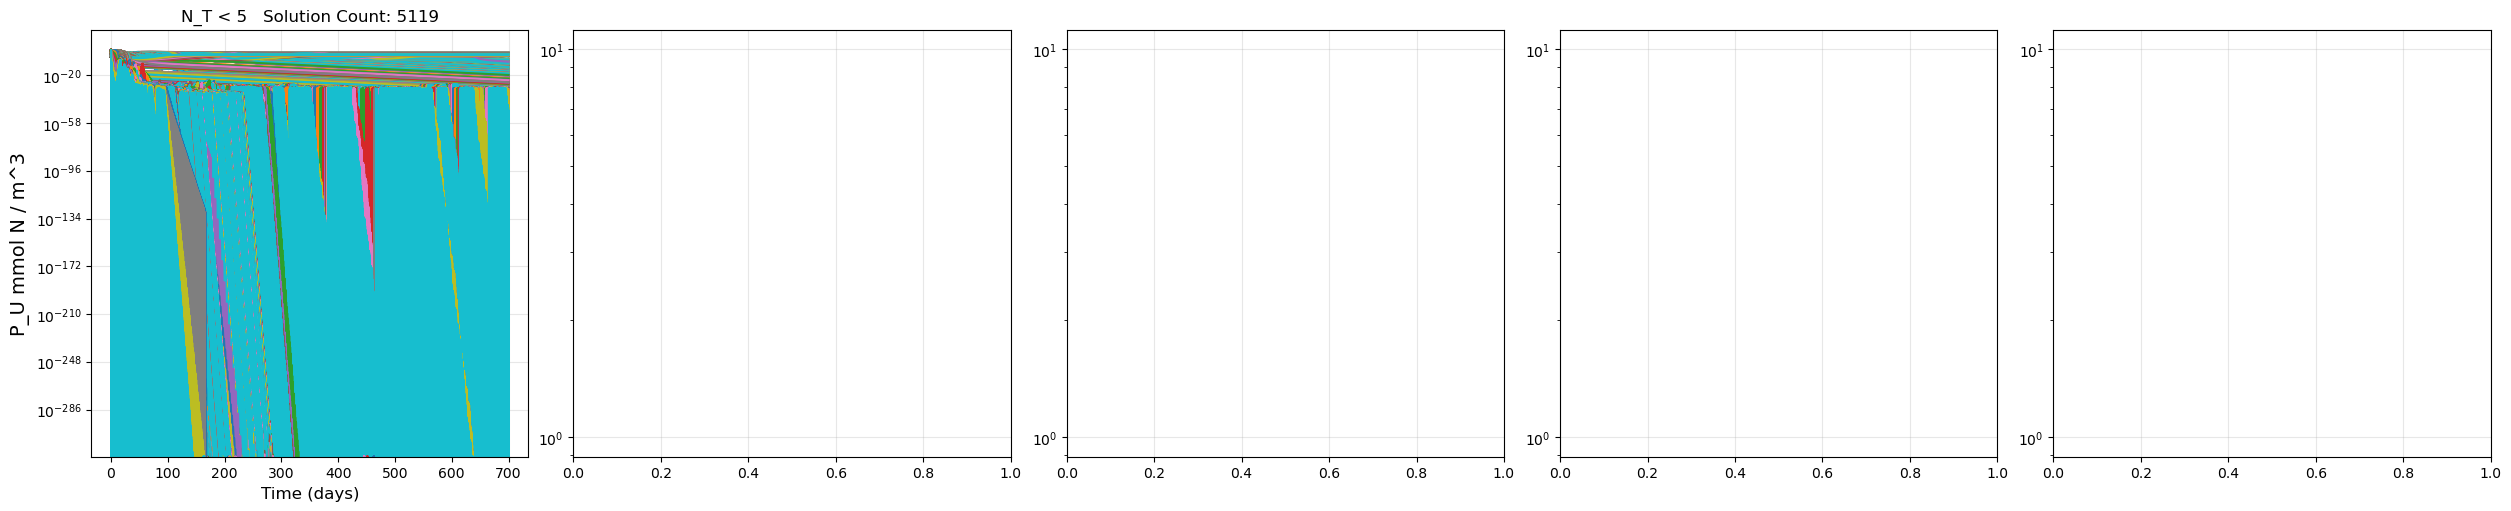

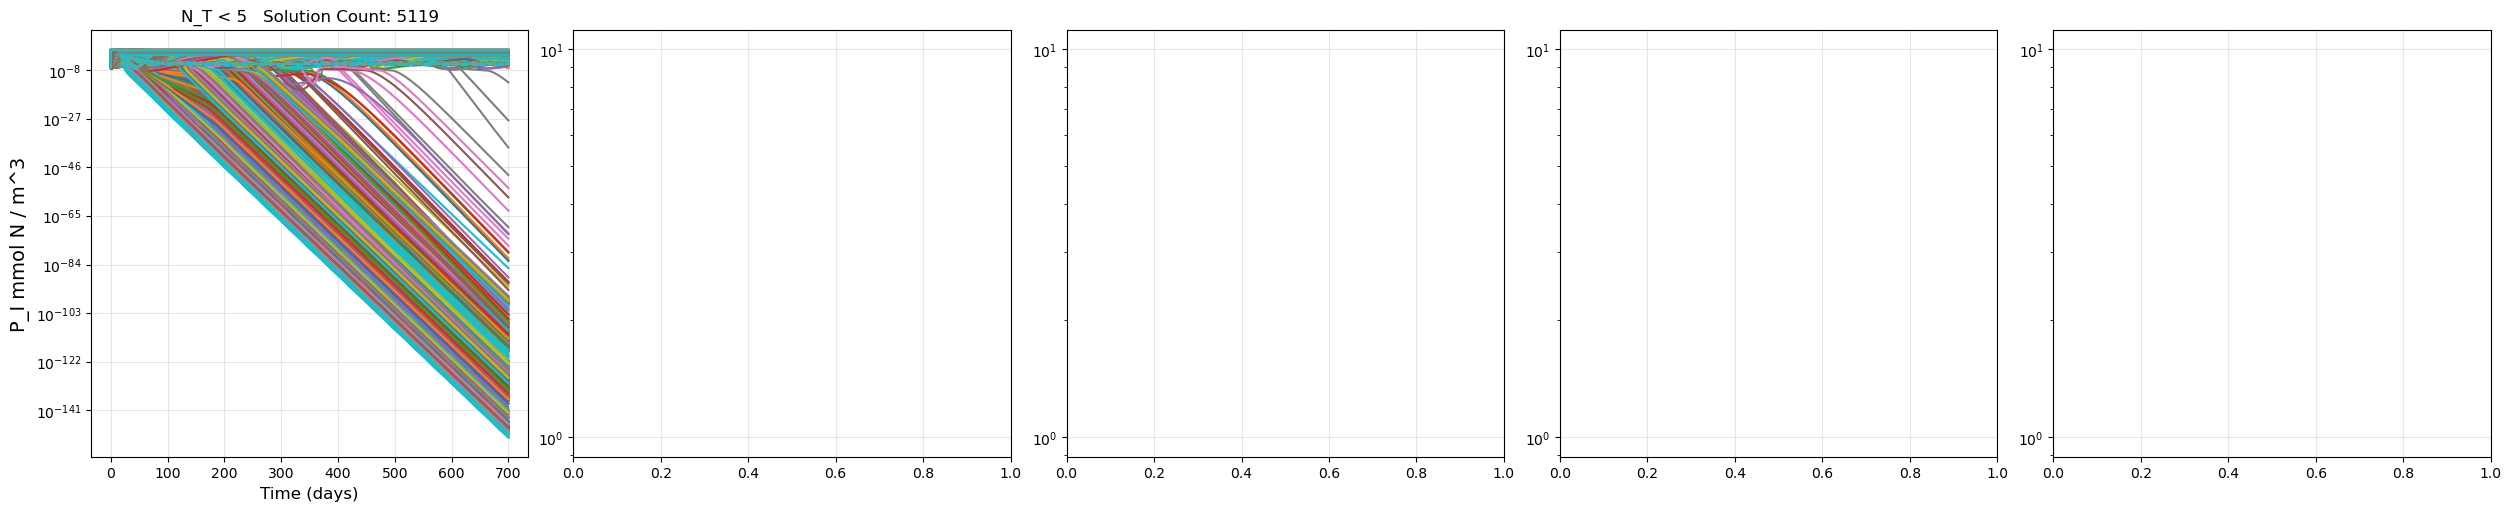

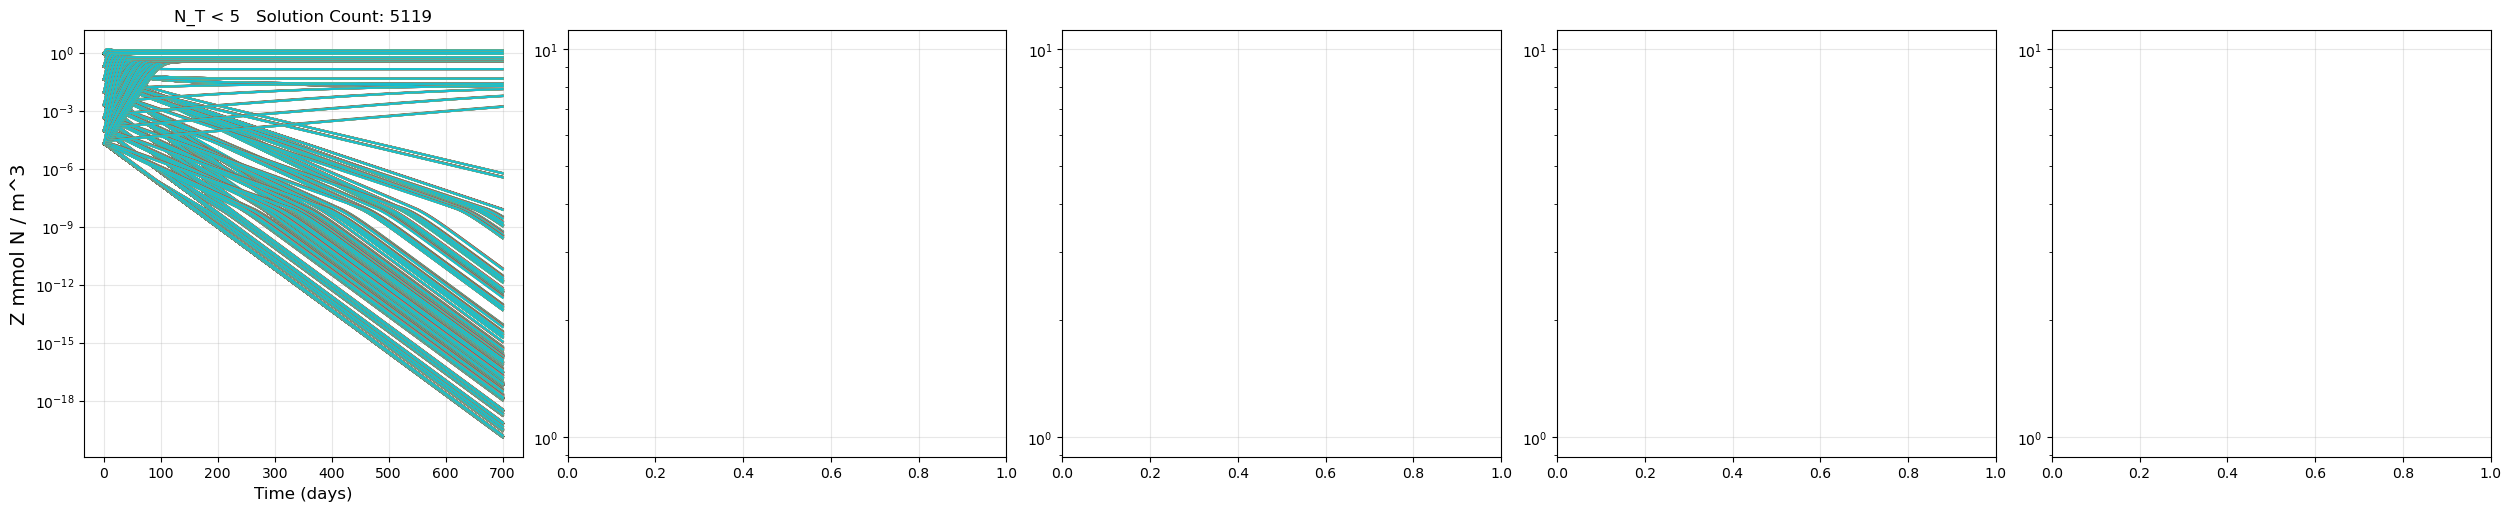

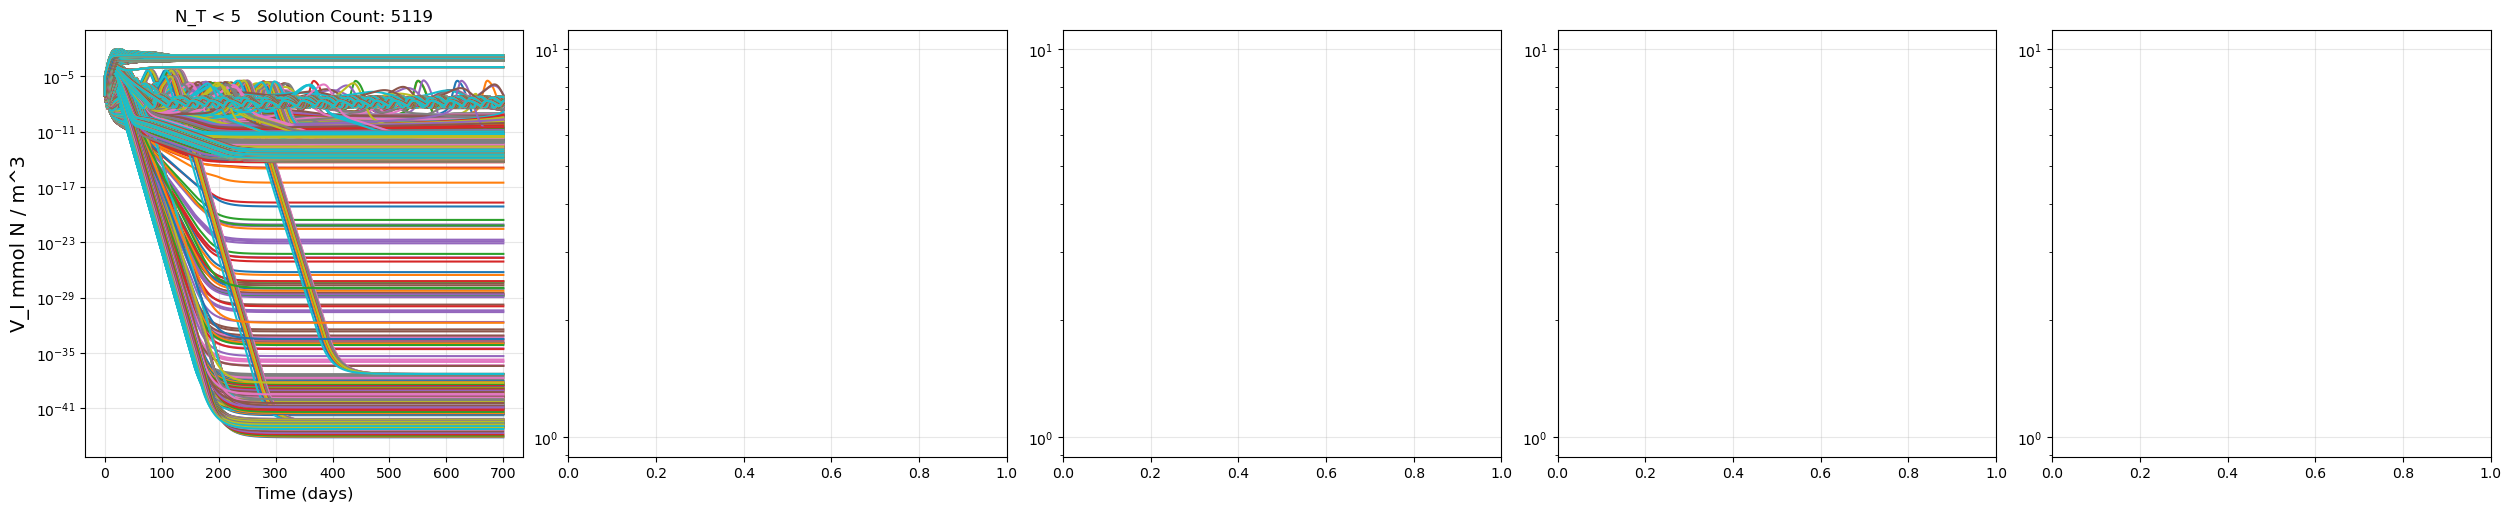

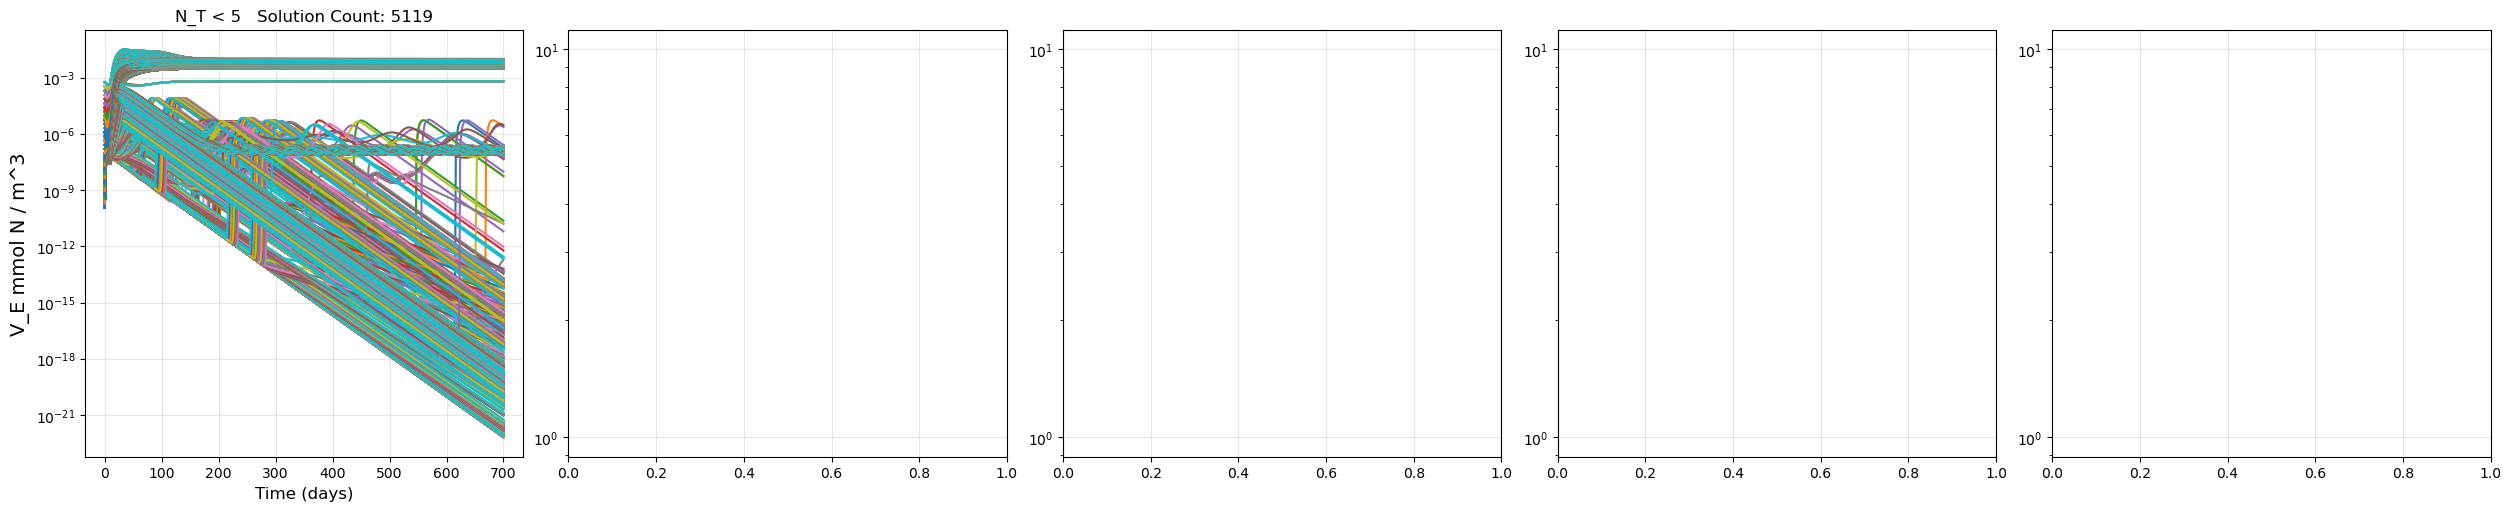

In [33]:
#Plotting solutions for each state variable depending on total N
%matplotlib inline

colors = ['darkgoldenrod', 'goldenrod', 'gold', "palegoldenrod", 'slategrey',
         'paleturquoise', 'cornflowerblue', 'royalblue', 'mediumblue', 'darkblue']

names = ['N_n', 'N_r', 'P_U', 'P_I', 'Z', 'V_I', 'V_E']

for k in range(1, 7):
    
    count0, count5, count10, count15, count20 = 0, 0, 0, 0, 0
    
    fig, axs = plt.subplots(1, 5, constrained_layout=True, figsize=(25, 5))
    
    for i, (z0, solution) in enumerate(sols):
        
        if sum(z0) < 5:
            axs[0].plot(solution.t, solution.y[k])
            axs[0].set_xlabel('Time (days)', fontsize=12)
            axs[0].set_ylabel(f'{names[k]} mmol N / m^3', fontsize=14)
            axs[0].set_title(f'N_T < 5   Solution Count: {count0}', fontsize=12)
            count0 += 1

        elif (sum(z0) >= 5) and (sum(z0) < 10):
            axs[1].plot(solution.t, solution.y[k])
            axs[1].set_xlabel('Time (days)', fontsize=12)
            axs[1].set_ylabel(f'{names[k]} mmol N / m^3', fontsize=14)
            axs[1].set_title(f'5 <= N_T < 10    Solution Count: {count5}', fontsize=12)
            count5 += 1

        elif (sum(z0) >= 10) and (sum(z0) < 15):
            axs[2].plot(solution.t, solution.y[k])
            axs[2].set_xlabel('Time (days)', fontsize=12)
            axs[2].set_title(f'10 <= N_T < 15   Solution Count: {count10}', fontsize=12)
            count10 += 1

        elif (sum(z0) >= 15) and (sum(z0) < 20):
            axs[3].plot(solution.t, solution.y[k])
            axs[3].set_xlabel('Time (days)', fontsize=12)
            axs[3].set_title(f'15 <= N_T < 20   Solution Count: {count15}', fontsize=12)
            count15 += 1

        else: 
            axs[4].plot(solution.t, solution.y[k])
            axs[4].set_xlabel('Time (days)', fontsize=12)
            axs[4].set_title(f'20 <= N_T <25   Solution Count: {count20}', fontsize=12)
            count20 += 1


    for ax in axs:
        ax.grid(alpha=.3)
        #ax.set_xlim(-10, 500)
        ax.set_yscale('log')
    plt.show()

In [ ]:
#Animation of progression of solutions
%matplotlib tk

time = [(z0, solution.t) for z0, solution in sols]

Nn = [solution.y[0] for z0, solution in sols]
Nr = [solution.y[1] for z0, solution in sols]
PU = [solution.y[2] for z0, solution in sols]
PI = [solution.y[3] for z0, solution in sols]
Z  = [solution.y[4] for z0, solution in sols]        
VI = [solution.y[5] for z0, solution in sols]
VE = [solution.y[6] for z0, solution in sols]

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_xlim(0, t_span)
ax.set_ylim(0, 10)

def animate(i):
    ax.clear()
     
    ax.plot(time[i][1], Nn[i], color="darkviolet", label = "N_n")
    ax.plot(time[i][1], Nr[i], color="blue"      , label = "N_r")
    ax.plot(time[i][1], PU[i], color="aquamarine", label = "P_U")
    ax.plot(time[i][1], PI[i], color="limegreen" , label = "P_I")
    ax.plot(time[i][1], Z [i], color="darkgreen" , label = "Z ")
    ax.plot(time[i][1], VI[i], color="red"       , label = "V_I")
    ax.plot(time[i][1], VE[i], color="darkred"   , label = "V_E")
    
#     con_index = converged(Nn[i])
#     ax.scatter(time[i][1][con_index], Nn[i][con_index], color='red')
    
#     con_index = converged(Nr[i])
#     ax.scatter(time[i][1][con_index], Nr[i][con_index], color='red')
    
#     con_index = converged(PU[i])
#     ax.scatter(time[i][1][con_index], PU[i][con_index], color='red')
    
#     con_index = converged(PI[i])
#     ax.scatter(time[i][1][con_index], PI[i][con_index], color='red')
    
#     con_index = converged(Z[i])
#     ax.scatter(time[i][1][con_index], Z[i][con_index], color='red')
    
#     con_index = converged(VI[i])
#     ax.scatter(time[i][1][con_index], VI[i][con_index], color='red')
    
#     con_index = converged(VE[i])
#     ax.scatter(time[i][1][con_index], VE[i][con_index], color='red')
    
    ax.legend(loc=(1.01, 0))
    ax.set_xlabel('Time (Day)')
    ax.set_ylabel('mmol N / m^3')
    ax.set_title(f'Total N: {sum(time[i][0]):.4}, for Nr_0 = {time[i][0][1]:.4}, Pu_0 = {time[i][0][2]:.4}, Pi_0 = {time[i][0][3]:.4}, Z_0 = {time[i][0][4]:.4}, Vi_0 = {time[i][0][5]:.4}, Ve_0 = {time[i][0][6]:.4}')

    ax.set_yscale('log')
    ax.set_ylim(1e-9, 1e2)
    ax.grid(alpha=.3)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(sols))
plt.show()

**Extracting steady state / late time tendancy** 

In [129]:
# Convergence scheme

def magnitude (value):
    """Returns the magnitude (10 ** m) of a given value"""
    if (value == 0): return 0
    return int(math.floor(math.log10(abs(value))))

def ss_or_osc(sol):
        
    """
    state_sol should be a list representing a solution for a particular 
    state variable associated with a particular solution set
    
    Convergence Criteria:

    - For state solution state_sol, set reference value to the last time iterate of state_solution.
    - Work backwards, comparing each time iterate to the reference value: want to find 
      the first instance of when the state_solution has strayed too far from the reference,
      as determined by a specified threshold.

    - That first instance represents the time of convergence.
    - Example: l = 5 (solution with 5 time steps)
               ref = sol[-1] = sol[4]
               convergence at i = 3 yields sol[-4] = sol[2] = sol(5 - 3)

    """
    chunk = int(len(sol.t) * .85) #Last 15% of time span
    ss = []
    conv_time = []
    
    for k in range(7):
        print(k)
        
        index = 0
        state_sol = sol.y[k]
                
        l = len(state_sol) #Amount of time steps in a solution

        ref = state_sol[-1] #Reference value for which we compare the previous values to
        ss.append(ref)
        
        mag = magnitude(ref * .01) # Define threshold at 1% of ref
        rel_tol = max(10 ** mag, 1e-10) # addresses exponential decay terms

        #Check if oscillations occur
        y_end = state_sol[chunk: ] #look at tail end of specific state

        l_min = argrelmin(y_end)[0]  #Extracting local minimum 
        l_max = argrelmax(y_end)[0]  #and maximum

        if (len(l_min) != 0) and (len(l_max) != 0): 
            return 'osc' # Return identifier, exit loop

        # If no oscillations present
        # Work backwards to find time of convergence
        for i in range(2, l): # Work backwards comparing each time step to the ref

            if not math.isclose(state_sol[-i], ref, rel_tol=rel_tol): 
                index = l - i + 1 #(plus 1 for previous time step, ie. last step that passed the threshold)
                break
        
        conv_time.append(index)
        
    return ss, conv_time
            

In [111]:
# Filtering oscillatory solutions - defining criteria

# Split limit cycling and steady state solutions into two groups

ss_sols = []
osc_sols = []

for z0, sol in sols: 
    
    info = ss_or_osc(sol)
    
    if info == 'osc':
        osc_sols.append((z0, sol))
        
    else:
        ss_sols.append((z0, sol) + info)

In [114]:
len(ss_sols)

4758

In [115]:
len(osc_sols)

362

In [14]:
%store ss_sols
%store osc_sols

Stored 'ss_sols' (list)
Stored 'osc_sols' (list)


 # Looking at Osc solution distribution

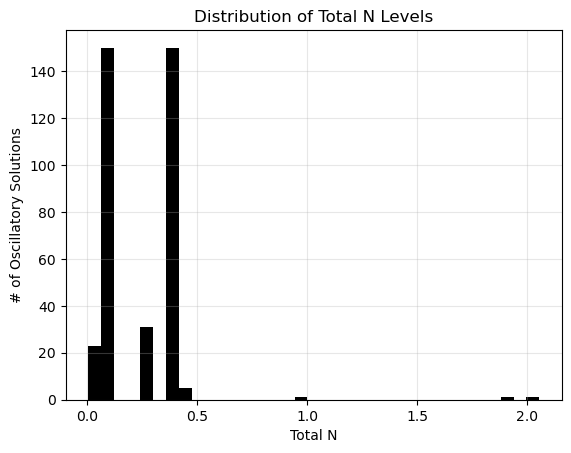

In [116]:
 #Check to see for which total N do the oscillatory solutions land 
osc_total_N = [sum(z0) for z0, sol in osc_sols]

osc_df = pd.DataFrame(osc_total_N, columns = ["Total N"])

plt.hist(osc_df, color='black', bins=35)
plt.title('Distribution of Total N Levels')
plt.ylabel("# of Oscillatory Solutions")
plt.xlabel("Total N")
plt.grid(alpha=.3)



**Plot osc solutions with total N > .5**

359
360
361


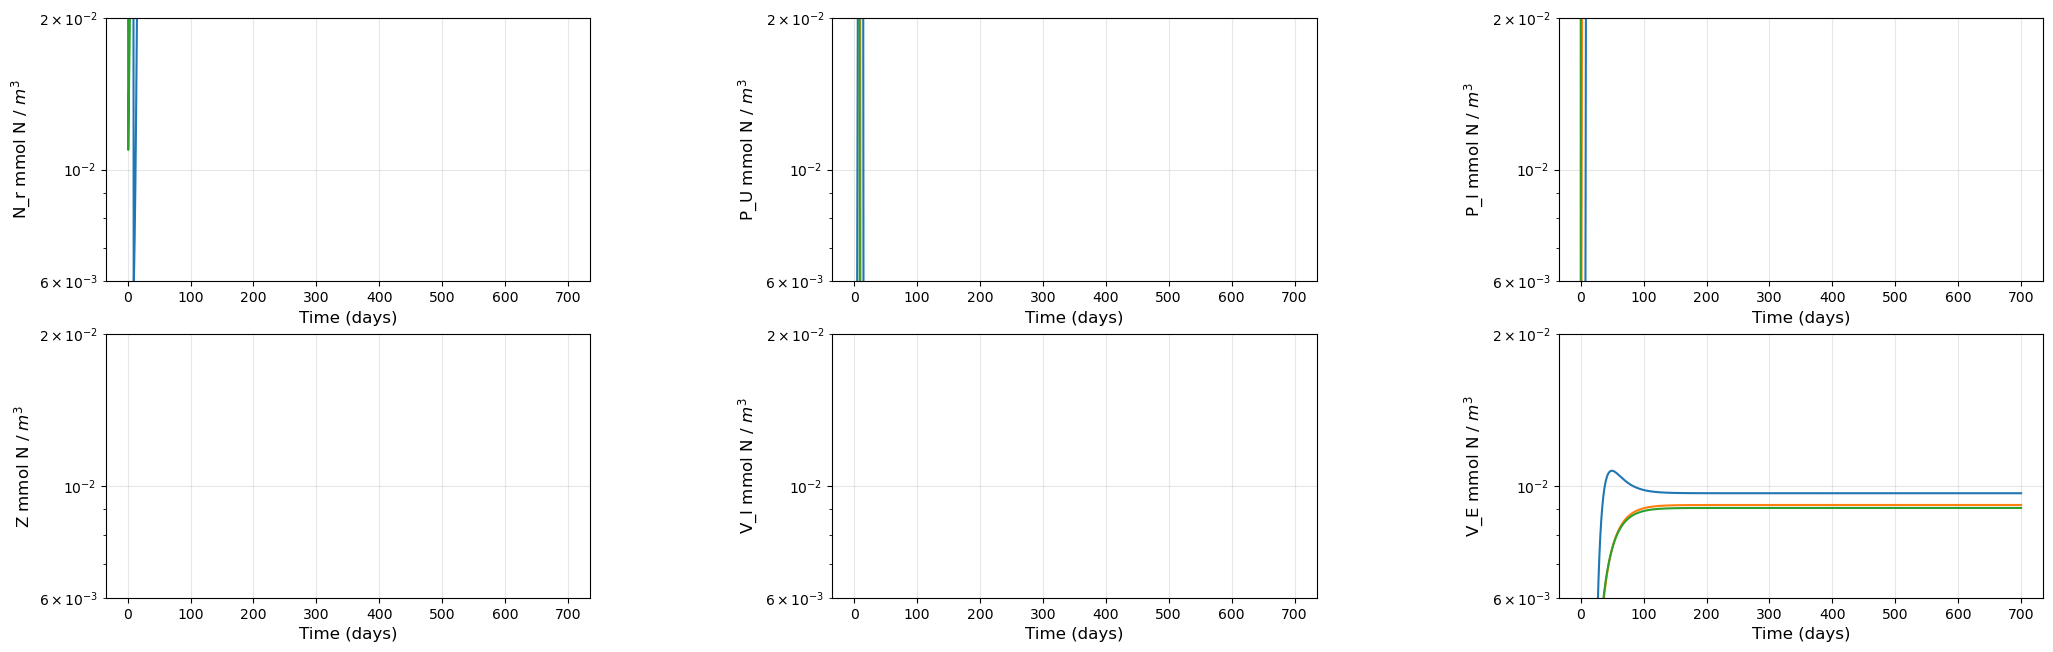

In [132]:
#Osc solutions with N_T > .5
%matplotlib inline

colors = ['darkgoldenrod', 'goldenrod', 'gold', "palegoldenrod", 'slategrey',
         'paleturquoise', 'cornflowerblue', 'royalblue', 'mediumblue', 'darkblue']

names = ['N_n', 'N_r', 'P_U', 'P_I', 'Z', 'V_I', 'V_E']

%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(25, 10))
fig.subplots_adjust(bottom=0.3, wspace=0.5)

for i, (z0, solution) in enumerate(osc_sols):
    
    if sum(z0) > .5:
        print(i)
        
        axs[0][0].plot(solution.t, solution.y[1])
        axs[0][0].set_ylabel(r'N_r mmol N / $m^3$', fontsize=12)

        axs[0][1].plot(solution.t, solution.y[2])
        axs[0][1].set_ylabel(r'P_U mmol N / $m^3$', fontsize=12)

        axs[0][2].plot(solution.t, solution.y[3])
        axs[0][2].set_ylabel(r'P_I mmol N / $m^3$', fontsize=12)

        axs[1][0].plot(solution.t, solution.y[4])
        axs[1][0].set_ylabel(r'Z mmol N / $m^3$', fontsize=12)

        axs[1][1].plot(solution.t, solution.y[5], label = f"N_T = {sum(z0):<10.3} z0 = {z0}")
        axs[1][1].set_ylabel(r'V_I mmol N / $m^3$', fontsize=12)

        axs[1][2].plot(solution.t, solution.y[6])
        axs[1][2].set_ylabel(r'V_E mmol N / $m^3$', fontsize=12)
    
    
for ax in axs:
    for subax in ax:
        subax.grid(alpha=.3)
        subax.set_xlabel('Time (days)', fontsize=12)
        subax.set_yscale('log')
        subax.set_ylim(6e-3, 2e-2)
plt.show()

The P_U solutions are being considered oscillatory when we would consider them to decay.....
Isolate solutions...

In [130]:
P_U_test = osc_sols[360][1].y[2]
N_r_test = osc_sols[360][1].y[1]

ss_or_osc(osc_sols[361][1])

# l = len(N_r_test) #Amount of time steps in a solution
# print('Time length: ', l)

# ref = N_r_test[-1] #Reference value for which we compare the previous values to
# print("Ref:", ref)

# rel_tol = max(ref * .01, 1e-10) # addresses exponential decay terms
# print("rel Tol:", rel_tol)

# #Check if oscillations occur
# chunk = int(len(osc_sols[361][1].t) * .85) #Last 15% of time span
# print("Starting Index:", chunk)

# y_end = N_r_test[chunk: ] #look at tail end of specific state

# l_min = argrelmin(y_end)[0]  #Extracting local minimum 
# l_max = argrelmax(y_end)[0]  #and maximum
# print(len(l_min), len(l_max))

# if (len(l_min) != 0) and (len(l_max) != 0): 
#     print('osc')

#Not oscillating yet still being considered an oscilatory solution?

0
1
2
3
4
5
6


([0.0,
  0.30913550777339627,
  0.0,
  0.7442909513968798,
  0.9923122900822595,
  0.0018651936442471847,
  0.009041144192061252],
 [0, 589, 0, 310, 540, 1217, 2508])

 # Looking at SS solutions

In [20]:
# want to create a data set where each solution's initial conditions are 
# paired with their respective steady state / long-time tendancy solution

labels = "N_n", "N_r", "P_U", "P_I", "Z", "V_I", "V_E"

data = []

for z0, sol, ss, conv_time in ss_sols:
    
     for k, state in enumerate(labels):

        data.append((state, z0[k], ss[k], sum(z0), sol.t[conv_time[k]]))


In [21]:
df = pd.DataFrame(data, columns = ['State Variable', 'Initial Condition', 'Steady State', 'Total N', "Convergence Time"])

In [22]:
df.head()

,State Variable,Initial Condition,Steady State,Total N,Convergence Time
0,N_n,0.000000e+00,0.000000e+00,0.00006,0.0
1,N_r,2.000000e-05,6.020012e-05,0.00006,314.2
2,P_U,2.000000e-05,2.745861e-16,0.00006,500.0
3,P_I,1.000000e-07,1.713216e-95,0.00006,500.0
4,Z,2.000000e-05,2.925751e-16,0.00006,500.0


In [23]:
# Separating data by state variable
Nn_df = df[df["State Variable"] == 'N_n'].drop(columns=['State Variable'])
Nr_df = df[df["State Variable"] == 'N_r'].drop(columns=['State Variable'])
Pu_df = df[df["State Variable"] == 'P_U'].drop(columns=['State Variable'])
Pi_df = df[df["State Variable"] == 'P_I'].drop(columns=['State Variable'])
Z_df  = df[df["State Variable"] == 'Z'  ].drop(columns=['State Variable'])
Vi_df = df[df["State Variable"] == 'V_I'].drop(columns=['State Variable'])
Ve_df = df[df["State Variable"] == 'V_E'].drop(columns=['State Variable'])


state_lists = (Nn_df, Nr_df, Pu_df, Pi_df, Z_df , Vi_df, Ve_df)

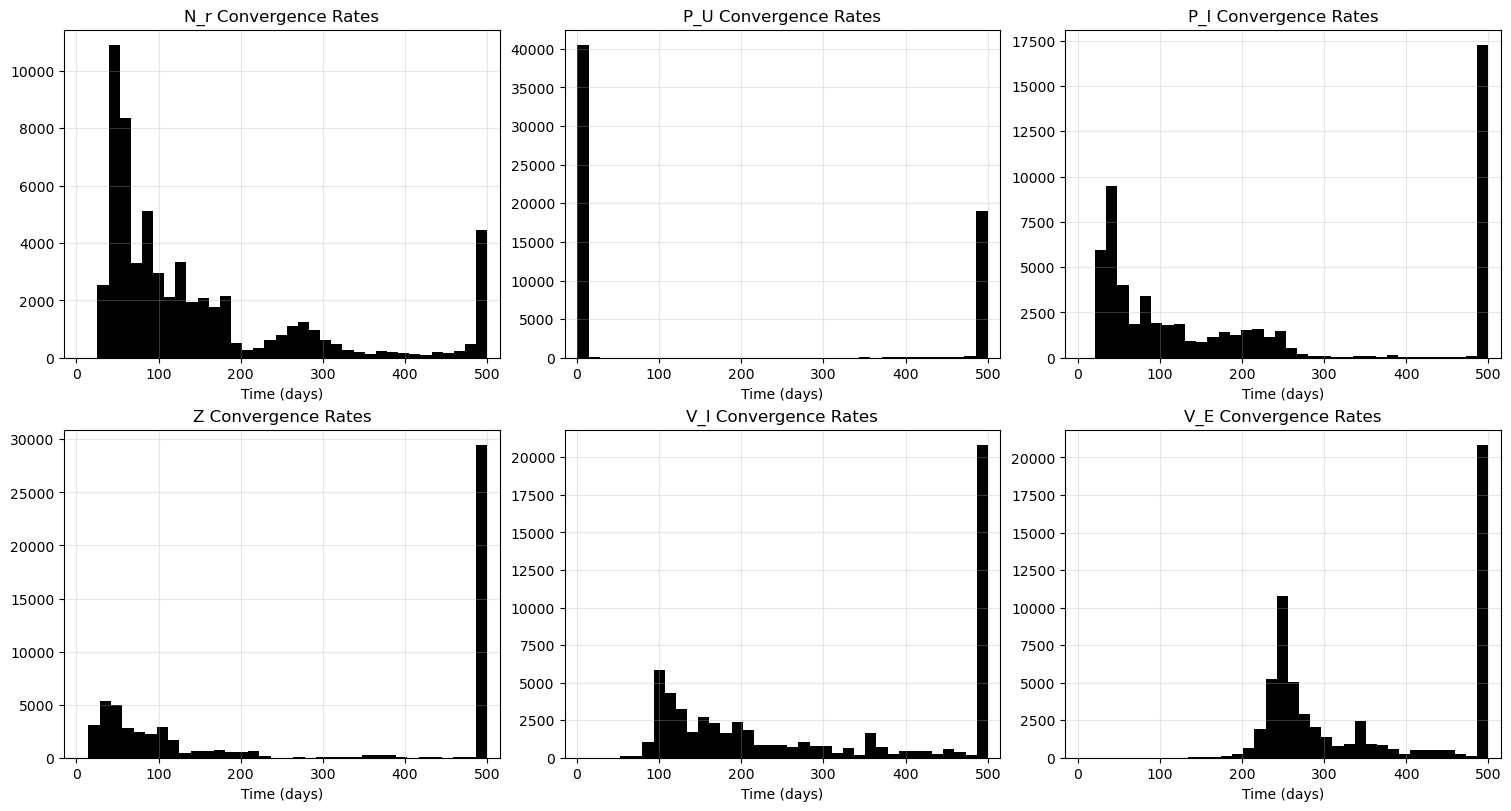

In [25]:
#Convergence Histograms
%matplotlib inline

fig, axs = plt.subplots(2, 3, figsize=(15, 8), constrained_layout = True)

count = 1 # starts at 1 to skip N_n
for row in range(2):
    for col in range(3):
        
        axs[row][col].hist(state_lists[count]['Convergence Time'], color='black', bins=35)
        axs[row][col].set_title(labels[count] + ' Convergence Rates')
        axs[row][col].grid(alpha=.3)
        
        #axs[row][col].set_yscale('log')
        axs[row][col].set_xlim(-15, 515)
        axs[row][col].set_xlabel('Time (days)')
        count += 1

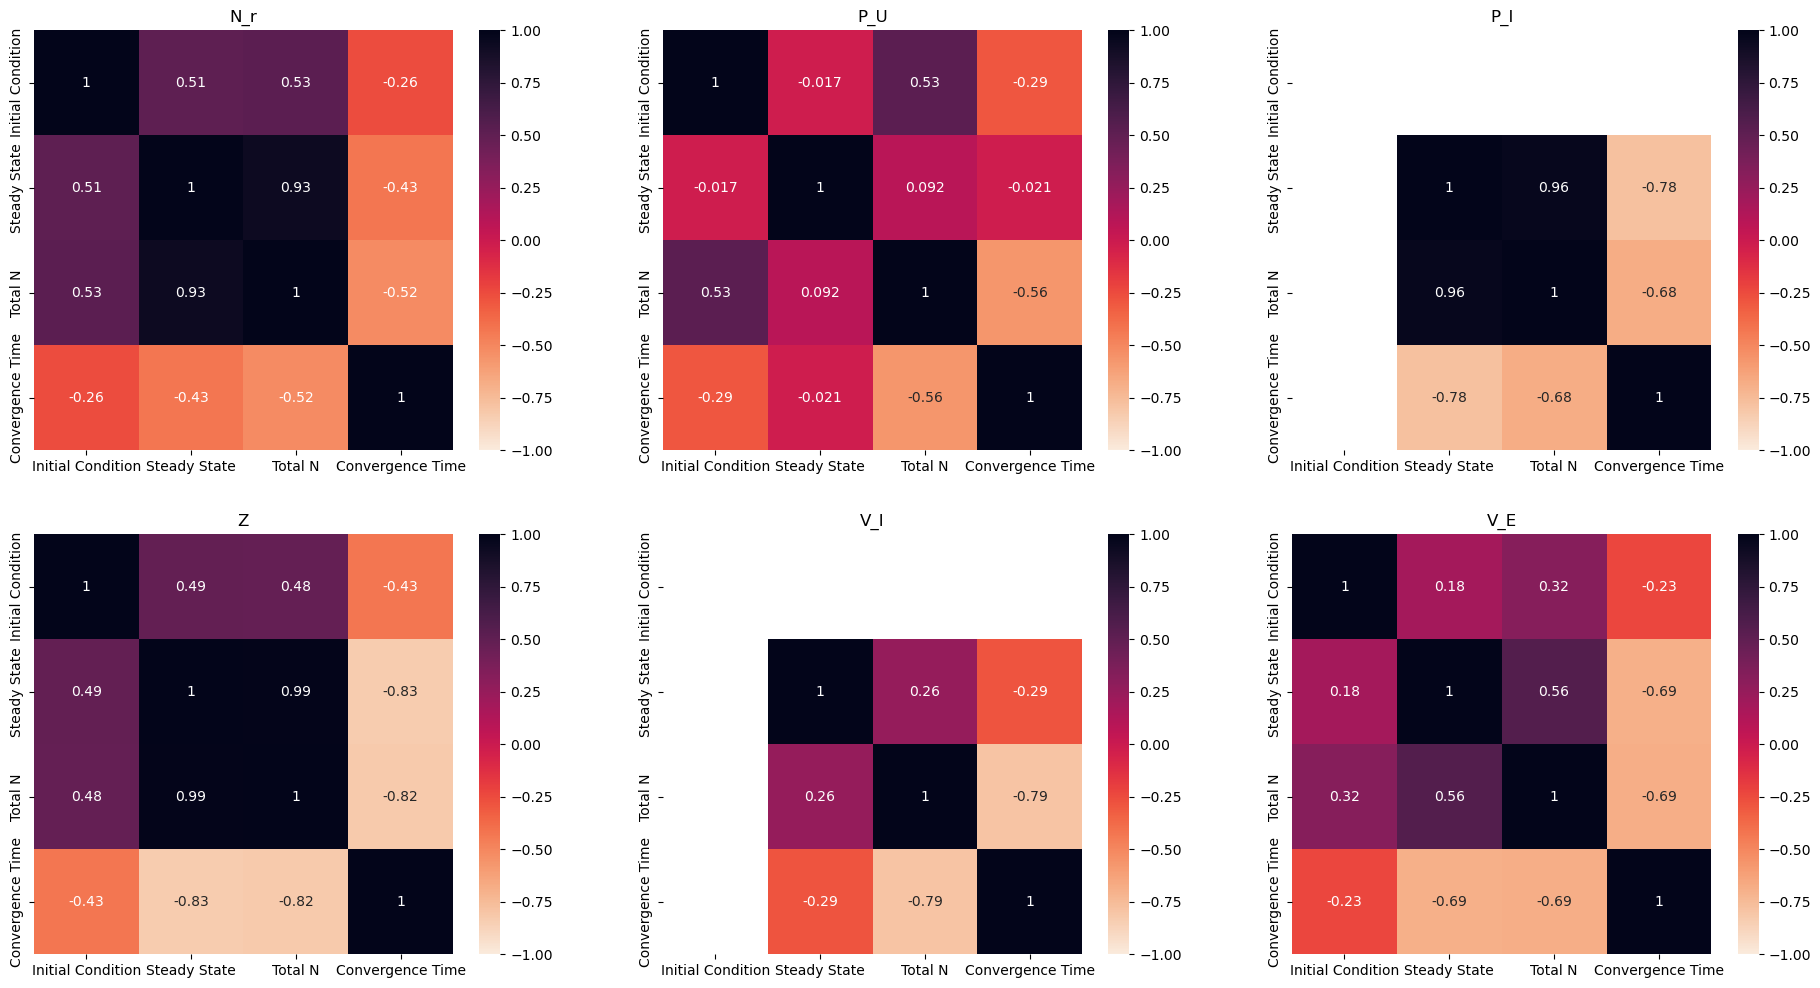

In [26]:
#Correlation Heatmaps
%matplotlib inline
import seaborn as sns

names = ['N_n', 'N_r', 'P_U', 'P_I', 'Z', 'V_I', 'V_E']

fig, axs = plt.subplots(2, 3, figsize=(23, 12))
i = 1

for row in range(2):
    for col in range(3):
        sns.heatmap(state_lists[i].corr(), cmap='rocket_r', annot=True, ax=axs[row][col], vmin=-1, vmax=1)
        axs[row][col].set_title(names[i])
        
        i += 1


In [ ]:
#Write function which checks to see if the same total N results
#in the mulitple unique steady state solutions

ss_data = []

for z0, sol, ss, conv_time in ss_sols:
        ss_data.append((sum(z0), ss))

ss_data = pd.DataFrame(ss_data, columns = ['Total N', 'SS'])
ss_data

ss_data["Total N"].duplicated().any()
        

In [ ]:
#didn't throw an error but doesnt work with lists (unhashible type: list)

In [ ]:
ss_data[1000:1010]